### **IMPORTS**

In [ ]:
!pip install mlxtend
!pip install catboost
!pip install xgboost
!pip install lightgbm
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split, cross_val_predict, StratifiedKFold, RepeatedStratifiedKFold, KFold
from sklearn.utils import resample
import imblearn
from lightgbm import LGBMClassifier
import gc
from numpy import loadtxt
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, r2_score, roc_curve, auc, mean_squared_error, log_loss, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from imblearn.over_sampling import SMOTE, SMOTENC
from catboost import CatBoostClassifier
from math import sqrt
import warnings
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from mlxtend.classifier import StackingCVClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from matplotlib import pyplot

warnings.filterwarnings("ignore")
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### **Functions**

In [ ]:
def plot_roc(meta_clf,level1_test, y_test):  
  
  
  n_classes = 3
  y_test = label_binarize(y_test, classes=[0,1,2])  # only for validation
  print(y_test)
  y_score = meta_clf.predict_proba(level1_test)
  print(y_score)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      print("(fpr[i], tpr[i]) = ",fpr[i], tpr[i] )
      roc_auc[i] = auc(fpr[i], tpr[i])

  print("ROC mean = ", np.mean(list(roc_auc.values())))
  # Plot of a ROC curve for a specific class
  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver operating characteristic example')
      plt.legend(loc="lower right")
      plt.show()

def preprocessing_outlier_removal(training_data):
  training_data.drop((training_data[training_data['Number_Weeks_does_not used'] > 40].index) & (training_data[training_data['Crop_status'] == 0].index), inplace = True)
  training_data.drop((training_data[training_data['Number_Weeks_does_not used'] > 33].index) & (training_data[training_data['Crop_status'] == 1].index), inplace = True)
  training_data.drop((training_data[training_data['Number_Weeks_does_not used'] > 20].index) & (training_data[training_data['Crop_status'] == 2].index), inplace = True)

  #weeks used clean up
  training_data.drop((training_data[training_data['Number_of_Weeks_Used'] > 58].index) & (training_data[training_data['Crop_status'] == 0].index), inplace = True)
  training_data.drop((training_data[training_data['Number_of_Weeks_Used'] < 14].index) & (training_data[training_data['Crop_status'] == 2].index), inplace = True)

  #does_count
  training_data.drop((training_data[training_data['Does_count'] > 76].index) & (training_data[training_data['Crop_status'] == 0].index), inplace = True)
  training_data.drop((training_data[training_data['Does_count'] > 45].index) & (training_data[training_data['Crop_status'] == 1].index), inplace = True)
  training_data.drop((training_data[training_data['Does_count'] > 73].index) & (training_data[training_data['Crop_status'] == 2].index), inplace = True)

  #insects
  training_data.drop((training_data[training_data['Insects'] > 3400].index) & (training_data[training_data['Crop_status'] == 0].index), inplace = True)
  training_data.drop((training_data[training_data['Insects'] > 3900].index) & (training_data[training_data['Crop_status'] == 2].index), inplace = True)

  return training_data

def countplot(df):
  sns.countplot(df)
  plt.show()

def scale(x):
  #scale data
  scaler = StandardScaler().fit(x)
  df = pd.DataFrame(scaler.transform(x), columns=list(x.columns))
  return df
  
def smote(X_train, y_train):
  #smote
  
  smote = SMOTE(random_state=42) 
  x_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
  x_train_smote = pd.DataFrame(x_train_smote, columns= list(X_train.columns))
  y_train_smote = pd.DataFrame(y_train_smote)

  return x_train_smote, y_train_smote

def smote_param(X_train, y_train, param = None):
  #smote
  if param is None:
    smote = SMOTE(random_state=42) 
  else: 
    smote = SMOTE(random_state=42, sampling_strategy = param)
  x_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
  x_train_smote = pd.DataFrame(x_train_smote, columns= list(X_train.columns))
  y_train_smote = pd.DataFrame(y_train_smote)

  return x_train_smote, y_train_smote


def smote_enc(X_train, y_train):
  #smote
  cat, ind = get_categ_list(X_train)
  smote = SMOTENC(random_state=42, categorical_features= ind) 
  x_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
  x_train_smote = pd.DataFrame(x_train_smote, columns= list(X_train.columns))
  y_train_smote = pd.DataFrame(y_train_smote)

  return x_train_smote, y_train_smote

def set_input(df, is_train_set = True, median_imputation = False, dummy = False):
  df.drop('ID', axis = 1, inplace = True)
  df.rename(columns={'Number_Weeks_does_not used': 'Number_Weeks_does_not_used'}, inplace=True)

  if is_train_set:
    X = df.drop("Crop_status", axis=1)
    y = df["Crop_status"]
  else:
    X = df

  if median_imputation:
    X.fillna(X["Number_of_Weeks_Used"].median(), axis = 1, inplace = True)
    X["Number_of_Weeks_Used"] = X["Number_of_Weeks_Used"].astype(np.int) 

  if dummy: 
    X=pd.get_dummies(X, columns= ["Crop","Soil", "Season"])
    X.drop('Soil_clay', axis = 1, inplace = True)
    X.drop('Crop_Feed', axis = 1, inplace = True)
    X.drop('Season_3', axis = 1, inplace = True)
  
  if is_train_set:
    return X,y
  else:
    return X

def print_classfn_metrics(y_pred, y_true, y_proba = None, is_yproba = False):
  print("Testing Accuracy ", accuracy_score(y_true, y_pred))
  print("F1 score ", f1_score(y_true, y_pred, average = 'None'))
  if is_yproba:
    print("Logloss score ", log_loss(y_true, y_proba))
  print(confusion_matrix(y_true, y_pred))
  print(classification_report(y_true, y_pred))


def download_csv(pred, name):

  from google.colab import files
  pd.DataFrame(pred).to_csv(name) 
  files.download(name)

def get_categ_list(X):
  categ_var_id = []
  categ_var = []
  for x in list(X.columns):
    if X[x].nunique() <= 3:
      categ_var_id.append(X.columns.get_loc(x))
      categ_var.append(x)
  return categ_var, categ_var_id

### **Stacking using stackingcv classifier**

In [ ]:
# Stackingcvclassifier



grid_parameters = [
    { # XGBoost
        'n_estimators': [400, 700, 1000],
        'colsample_bytree': [0.7, 0.8],
        'max_depth': [15,20,25],
        'reg_alpha': [1.1, 1.2, 1.3],
        'reg_lambda': [1.1, 1.2, 1.3],
        'subsample': [0.7, 0.8, 0.9]
    },
    { # LightGBM
        'n_estimators': [400, 700, 1000],
        'learning_rate': [0.12],
        'colsample_bytree': [0.7, 0.8],
        'max_depth': [4],
        'num_leaves': [10, 20],
        'reg_alpha': [1.1, 1.2],
        'reg_lambda': [1.1, 1.2],
        'min_split_gain': [0.3, 0.4],
        'subsample': [0.8, 0.9],
        'subsample_freq': [10, 20]
    }, 
    { # Random Forest
        'max_depth':[3, 5, 10, 13], 
        'n_estimators':[100, 200, 400, 600, 900],
        'max_features':[2, 4, 6, 8, 10]
    },
    # Support Vector Classifier parameters 
    {
    'kernel' : 'linear',
    'C' : 0.025
    },
    # AdaBoost parameters
{
    'n_estimators': 500,
    'learning_rate' : 0.75
}

]


training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

training_data.drop(training_data[training_data['Crop_status'] == 2].index, inplace = True)

X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)

#y = label_binarize(y, classes=[0,1,2])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

X_train = X
y_train = y
X_test = test_df_off

X_train_sm, y_train_sm = smote_param(X_train,y_train, param= 0.35)
y_train_sm.columns = ['Crop_status']

categ_var, categ_var_id = get_categ_list(X_train)

#meta
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9, colsample_bynode= 1, colsample_bytree=1, 
                    gamma= 2.8, interaction_constraints='', learning_rate=0.01, max_delta_step=1, 
                    max_depth= 4, min_child_weight=4.2, missing=None, n_estimators=1000, 
                    num_parallel_tree=1, random_state=0, reg_alpha=0.5, reg_lambda=1, 
                    seed=None, silent=None, subsample=0.7) 


lgbm = lgb.LGBMClassifier(max_depth = 4, n_estimators = 1000)

cat = CatBoostClassifier(
    max_depth = 5,
    iterations=888, 
    learning_rate=0.07, 
    cat_features=categ_var_id,
    leaf_estimation_method= 'Newton',
    random_strength = 0.9,
    boosting_type = 'Ordered',
    sampling_frequency= 'PerTreeLevel',
    l2_leaf_reg = 2,
    random_state = 42

)

lr = LogisticRegression(C = 0.5) # smaller C, more reg
rf = RandomForestClassifier(max_depth = 4, n_estimators= 500, max_features='sqrt')
knn = KNeighborsClassifier(n_neighbors=10)
gnb = GaussianNB()

stack = StackingCVClassifier(classifiers=(cat, lgbm, lr, knn, gnb),
                            meta_classifier=xgb, cv=4,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False, stratify = True, use_probas = True)

#stack.fit(X_train.values, y_train.values)
stack.fit(X_train_sm.values, y_train_sm.values)
#X_train.columns = categ_var
y_pred = stack.predict(X_test)

download_csv(y_pred, 'stacking_class_True.csv')

# plot_roc(stack, X_test, y_test)
# print_classfn_metrics(y_pred, y_test, y_proba = None, is_yproba = False)

TypeError: ignored

In [ ]:
y_train_sm.dtypes

Crop_status    int64
dtype: object

### **Crude Stacking with MSE**

In [ ]:
#crude stacking -xgb-lgb,catb,rf

NFOLDS = 5
SEED = 0
NROWS = None


training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)

#train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
ntrain = x_train.shape[0]
ntest = x_test.shape[0]

#whole dataset
# x_train = X
# y_train = y
# x_test = test_df_off
# ntrain = X.shape[0]
# ntest = test_df_off.shape[0]

kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

class SklearnWrapper_no_rs(object):
    def __init__(self, clf, seed=0, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        #return self.clf.predict_proba(x)[:,1]
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]


class XgbWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        self.param = params
        self.clf = clf(**params)
        params['seed'] = seed
        
        #self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        # dtrain = xgb.DMatrix(x_train, label=y_train)
        # self.gbdt = xgb.train(self.param, dtrain, self.nrounds)
        self.clf.fit(x_train, y_train)
    def predict(self, x):
        #return self.gbdt.predict(xgb.DMatrix(x))
        return self.clf.predict_proba(x)[:,1]

def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


et_params = {
    'n_jobs': 16,
    'n_estimators': 10,
    'max_features': 0.5,
    'max_depth': 12,
    #'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 10,
    'max_features': 0.2,
    'max_depth': 12,
    #'min_samples_leaf': 2,
}

xgb_params = {
    'objective': 'multi:softprob',
    'eta':0.1,
    'max_depth':6,
    'num_class':3,
    'eval_metric':"mlogloss",
    'min_child_weight': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.7
}


catboost_params = {
    # 'iterations': 888,
    # 'learning_rate': 0.5,
    # 'depth': 5,
    # 'l2_leaf_reg': 40,
    # 'bootstrap_type': 'Bernoulli',
    # 'subsample': 0.7,
    #'scale_pos_weight': 5,
    'eval_metric': 'MultiClass',
    # 'od_type': 'Iter',
    # 'allow_writing_files': False,
    'loss_function': 'MultiClass',
    'classes_count': 3,
    # 'random_strength': 0.9,
    # 'boosting_type': 'Ordered'
}

lightgbm_params = {
    # 'n_estimators':200,
    # 'learning_rate':0.1,
    # 'num_leaves':123,
    # 'colsample_bytree':0.8,
    # 'subsample':0.9,
    # 'max_depth':15,
    # 'reg_alpha':0.1,
    # 'reg_lambda':0.1,
    # 'min_split_gain':0.01,
    # 'min_child_weight':2    
}
knn_params = {'n_neighbors': 100}

# knn = SklearnWrapper_no_rs(clf = KNeighborsClassifier, params = knn_params)
# gnb = SklearnWrapper_no_rs(clf = GaussianNB, params = {})

xg = XgbWrapper(clf = XGBClassifier, seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
# rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
# cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params)
# lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params)

xg_oof_train, xg_oof_test = get_oof(xg)
et_oof_train, et_oof_test = get_oof(et)
# rf_oof_train, rf_oof_test = get_oof(rf)
# cb_oof_train, cb_oof_test = get_oof(cb)
# lg_oof_train, lg_oof_test = get_oof(lg)
# knn_oof_train, knn_oof_test = get_oof(knn)
# gnb_oof_train, gnb_oof_test = get_oof(gnb)

print("XG-CV: {}".format(sqrt(mean_squared_error(y_train, xg_oof_train))))
print("ET-CV: {}".format(sqrt(mean_squared_error(y_train, et_oof_train))))
# print("RF-CV: {}".format(sqrt(mean_squared_error(y_train, rf_oof_train))))
# print("cb-CV: {}".format(sqrt(mean_squared_error(y_train, cb_oof_train))))
# print("LG-CV: {}".format(sqrt(mean_squared_error(y_train, lg_oof_train))))
# print("knn-CV: {}".format(sqrt(mean_squared_error(y_train, knn_oof_train))))
# print("gnb-CV: {}".format(sqrt(mean_squared_error(y_train, gnb_oof_train))))

x_train = np.concatenate((xg_oof_train, et_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test, et_oof_test), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))

logistic_regression = LogisticRegression()
logistic_regression.fit(x_train,y_train)

predictions= logistic_regression.predict(x_test)

plot_roc(logistic_regression, x_test, y_test)
print_classfn_metrics(predictions, y_test, y_proba = None, is_yproba = False)


## **Crude stacking specially tailored for 3 classes. One of my go to**

In [ ]:
#crude stacking -xgb-lgb,catb,rf different twist, multiclass
SEED = 42
NFOLDS = 5
SEED = 42
NROWS = None
n_classes=2

class SklearnWrapper_no_rs(object):
    def __init__(self, clf, seed=0, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict_probability(self, x):
        return self.clf.predict_proba(x)

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict_probability(self, x):
        proba = self.clf.predict_proba(x)
        return proba

class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 30)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict_probability(self, x):
        proba = self.gbdt.predict(xgb.DMatrix(x))
        return proba

class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict_probability(self, x):
        return self.clf.predict_proba(x)
        
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict_probability(self, x):
        return self.clf.predict_proba(x)



def get_oof(clf):
    print("Get oof of ", clf)
    oof_train = np.zeros((ntrain,n_classes))
    oof_test = np.zeros((ntest,n_classes))
    oof_test_skf = np.empty((ntest, NFOLDS*n_classes))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict_probability(x_te)
        oof_test_skf[:,2*i: 2*i + 2] = clf.predict_probability(x_test)
        print("For splitting")

    print(oof_test_skf.shape)

    for i in range(2):
        oof_test[:,i] = (oof_test_skf[:,i]+oof_test_skf[:,i+2] + oof_test_skf[:,i+4] + oof_test_skf[:,i+6] + oof_test_skf[:,i+8])/5

    #oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test



et_params = {
    'n_jobs': 16,
    'n_estimators': 10,
    'max_features': 0.5,
    'max_depth': 12,
    #'min_samples_leaf': 2,
}

rf_params = {
    'n_estimators': 70,
    'max_features': 0.8,
    'max_depth': 5,
    'class_weight': 'balanced'
    #'min_samples_leaf': 2,
}

xgb_params = {
    'objective': 'multi:softprob',
    'eta':0.1,
    'max_depth':6,
    'num_class':3,
    'eval_metric':"mlogloss",
    'min_child_weight': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.7
}

svc_params = {
    'kernel' : 'linear',
    'C' : 0.025,
    'probability': True
    }


catboost_params = {'max_depth': 5,
                   'iterations': 888,
                   'learning_rate': 0.07,
                   'loss_function': 'MultiClass',
                   'early_stopping_rounds': 200,
                   'random_seed': SEED,
                   'classes_count': 3,
                   'cat_features':[0,1,2,3,4,5,6,7,8],
                   'leaf_estimation_method': 'Newton',
                   'random_strength': 0.9,
                   'boosting_type': 'Ordered',
                   'sampling_frequency': 'PerTreeLevel',
                   'l2_leaf_reg': 2
                   }

bagging_params = {
    'n_estimators': 100,
}

knn_params  = {
    'n_neighbors': 10
}
gnb_params = {
    'var_smoothing': 1e-9
}




training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

#training_data = preprocessing_outlier_removal(training_data)
training_data.drop(training_data[training_data['Crop_status'] == 2].index, inplace = True)

X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)

#train test split
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
# x_train, y_train = smote_param(x_train, y_train)

# ntrain = x_train.shape[0]
# ntest = x_test.shape[0]

#whole dataset
x_train = X
y_train = y
#n0, n1, n2 = y.value_counts()
# smote_ratio = {0:n0, 1: 3 * n1, 2: n2}
# #x_train, y_train = smote_param(x_train, y_train, smote_ratio)
x_test = test_df_off
ntrain = x_train.shape[0]
ntest = x_test.shape[0]


kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)



#rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
#svm = SklearnWrapper(clf=SVC, seed=SEED, params=svc_params)
#et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
knn = SklearnWrapper_no_rs(clf = KNeighborsClassifier, params = knn_params)
gnb = SklearnWrapper_no_rs(clf = GaussianNB, params= gnb_params)
#xg = XgbWrapper(seed=SEED, params=xgb_params)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params)
bagging_class = SklearnWrapper(clf= BaggingClassifier, seed = SEED, params=bagging_params)
#cb_bal = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params_bal)

knn_oof_train, knn_oof_test = get_oof(knn)
gnb_oof_train, gnb_oof_test = get_oof(gnb)
#rf_oof_train, rf_oof_test = get_oof(rf)
# #et_oof_train, et_oof_test = get_oof(et)
cb_oof_train, cb_oof_test = get_oof(cb)
bagging_class_oof_train, bagging_class_oof_test = get_oof(bagging_class)

print("knn-CV: {}".format(log_loss(y_train, knn_oof_train)))
print("gnb-CV: {}".format(log_loss(y_train, gnb_oof_train)))
# print("XG-CV: {}".format(log_loss(y_train, xg_oof_train)))
# # print("ET-CV: {}".format(log_loss(y_train, et_oof_train)))
print("CB-CV: {}".format(log_loss(y_train, cb_oof_train)))
print("BC-CV: {}".format(log_loss(y_train, bagging_class_oof_train)))
#print("RF-CV: {}".format(log_loss(y_train, rf_oof_train)))


x_train = np.concatenate((gnb_oof_train, knn_oof_train, cb_oof_train, bagging_class_oof_train), axis=1)
x_test = np.concatenate((gnb_oof_test, knn_oof_test, cb_oof_test, bagging_class_oof_test), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))


dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

xgb_params = {
    'objective': 'multi:softprob',
    'eta':0.1,
    #'max_depth':2,
    'num_class':3,
    'eval_metric':"mlogloss",
    'min_child_weight': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.7
}

alg = XGBClassifier(**xgb_params)

res = xgb.cv(xgb_params, dtrain, num_boost_round=200, nfold=3, seed=SEED,
             early_stopping_rounds=10, show_stdv=True, stratified = True)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]


print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))

alg.set_params(n_estimators=best_nrounds)

# #gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
# out_df = pd.DataFrame(gbdt.predict(dtest))

alg.fit(x_train, y_train)
out_df = pd.DataFrame(alg.predict(x_test))
download_csv(out_df, 'trail_3.csv')
#plot_roc(alg, x_test, y_test)
#print_classfn_metrics(out_df, y_test, y_proba = None, is_yproba = False)

Get oof of  <__main__.SklearnWrapper_no_rs object at 0x7f371bec16a0>
For splitting
For splitting
For splitting
For splitting
For splitting
(35000, 10)
Get oof of  <__main__.SklearnWrapper_no_rs object at 0x7f371bec1ac8>
For splitting
For splitting
For splitting
For splitting
For splitting
(35000, 10)
Get oof of  <__main__.CatboostWrapper object at 0x7f3740ca7b70>


Found only 2 unique classes in the data, but have defined 3 classes. Probably something is wrong with data.


0:	learn: 0.6562248	total: 237ms	remaining: 3m 30s
1:	learn: 0.6244376	total: 400ms	remaining: 2m 57s
2:	learn: 0.5964471	total: 628ms	remaining: 3m 5s
3:	learn: 0.5720799	total: 889ms	remaining: 3m 16s
4:	learn: 0.5507079	total: 1.13s	remaining: 3m 20s
5:	learn: 0.5318552	total: 1.32s	remaining: 3m 13s
6:	learn: 0.5151881	total: 1.55s	remaining: 3m 14s
7:	learn: 0.5004279	total: 1.76s	remaining: 3m 14s
8:	learn: 0.4870848	total: 1.99s	remaining: 3m 14s
9:	learn: 0.4752100	total: 2.2s	remaining: 3m 13s
10:	learn: 0.4646406	total: 2.42s	remaining: 3m 13s
11:	learn: 0.4552280	total: 2.71s	remaining: 3m 18s
12:	learn: 0.4470332	total: 2.96s	remaining: 3m 18s
13:	learn: 0.4378966	total: 3.24s	remaining: 3m 22s
14:	learn: 0.4289286	total: 3.53s	remaining: 3m 25s
15:	learn: 0.4209757	total: 3.8s	remaining: 3m 27s
16:	learn: 0.4138800	total: 4.08s	remaining: 3m 29s
17:	learn: 0.4074043	total: 4.37s	remaining: 3m 31s
18:	learn: 0.4018062	total: 4.64s	remaining: 3m 32s
19:	learn: 0.3964226	tota

ValueError: ignored

### **Current reference**

In [ ]:
def smote_param(X_train, y_train, param = None):
  #smote
  if param is None:
    smote = SMOTE(random_state=42) 
  else: 
    smote = SMOTE(random_state=42, ratio = param)
  x_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
  x_train_smote = pd.DataFrame(x_train_smote, columns= list(X_train.columns))
  y_train_smote = pd.DataFrame(y_train_smote)

  return x_train_smote, y_train_smote

training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

# training_data['categ_2_3'] = [1 if x == 2 or x == 3 else 0 for x in training_data['Category_of_Toxicant']]

#training_data = preprocessing_outlier_removal(training_data)

# training_data['Crop_status'].replace([2], 1, inplace = True)
training_data.drop(training_data[training_data['Crop_status'] == 2].index, inplace = True)
# feature engineering
# training_data['weeks_used_fe'] = [1 if x < 14 else 0 for x in training_data['Number_of_Weeks_Used']]
# training_data['does_count_fe'] = [1 if x > 44 else 0 for x in training_data['Does_count']]
#training_data['does_not_used_fe'] = [1 if x > 44 else 0 for x in training_data['Number_Weeks_does_not used']]



X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)

#n0, n1, n2 = y.value_counts()
#smote_ratio = {0:n0, 1: 3*n1 + 8000, 2: 6* n2 + 4000}


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

x_train = X
y_train = y
x_test = test_df_off
# p = list(np.arange(0.2,1, 0.02))
# f1 = []
# for x in p:
#x_train, y_train = smote_param(x_train,y_train, param= 0.45)

categ_var, categ_var_id = get_categ_list(x_train)


clf = CatBoostClassifier(
    max_depth = 5,
    iterations=1000, 
    learning_rate=0.07, 
    #loss_function='MultiClass',
    early_stopping_rounds = 100,
    random_seed = 42,
    #classes_count = 3,
    cat_features=categ_var_id,
    #auto_class_weights = 'Balanced',
    leaf_estimation_method= 'Newton',
    random_strength = 0.9,
    boosting_type = 'Ordered',
    sampling_frequency= 'PerTreeLevel',
    l2_leaf_reg = 2
)
#clf = LGBMClassifier(random_state = 42)
# clf = LGBMClassifier(
#                         objective='multiclass',
#                         boosting_type='gbdt',
#                         n_estimators=2000,
#                         early_stopping_rounds = 100,
#                         random_state = 42,
#                         #metric='auc',
#                         learning_rate=0.2,
#                         num_leaves=50,
#                         reg_alpha=0.3,
#                         reg_lambda=0.2,
#                         ) #is_unbalance = True

#clf = CalibratedClassifierCV(clf, method='isotonic', cv=3)
#clf.fit(X, y)

clf.fit(x_train, y_train,  
        #eval_set=(x_test, y_test),
        verbose=True,
        #plot = True
)

prediction = pd.DataFrame(clf.predict(x_test))
# f1.append((x, f1_score(y_test, prediction, average = None)))
# print_classfn_metrics(prediction, y_test, y_proba = None, is_yproba = False)

# print(prediction.value_counts())
download_csv(prediction, 'trail_2.csv')


# print("Real")
# print(y_test.value_counts())
# print("Predicted")
# print(prediction.value_counts())

# # plot_roc(clf, x_test, y_test)
#print_classfn_metrics(prediction, y_test, y_proba = None, is_yproba = False)

0:	learn: 0.6781856	total: 102ms	remaining: 1m 42s
1:	learn: 0.6664354	total: 201ms	remaining: 1m 40s
2:	learn: 0.6553337	total: 312ms	remaining: 1m 43s
3:	learn: 0.6455960	total: 457ms	remaining: 1m 53s
4:	learn: 0.6360130	total: 573ms	remaining: 1m 53s
5:	learn: 0.6272309	total: 689ms	remaining: 1m 54s
6:	learn: 0.6197639	total: 812ms	remaining: 1m 55s
7:	learn: 0.6137125	total: 921ms	remaining: 1m 54s
8:	learn: 0.6080663	total: 1.01s	remaining: 1m 51s
9:	learn: 0.6030661	total: 1.13s	remaining: 1m 51s
10:	learn: 0.5984131	total: 1.24s	remaining: 1m 51s
11:	learn: 0.5943874	total: 1.34s	remaining: 1m 50s
12:	learn: 0.5907956	total: 1.45s	remaining: 1m 50s
13:	learn: 0.5877217	total: 1.55s	remaining: 1m 49s
14:	learn: 0.5847837	total: 1.66s	remaining: 1m 49s
15:	learn: 0.5823584	total: 1.78s	remaining: 1m 49s
16:	learn: 0.5806724	total: 1.89s	remaining: 1m 49s
17:	learn: 0.5787138	total: 2s	remaining: 1m 49s
18:	learn: 0.5769835	total: 2.11s	remaining: 1m 48s
19:	learn: 0.5755122	tota

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
f1

[(0.2, array([0.92831035, 0.45693902])),
 (0.22, array([0.92770705, 0.46646746])),
 (0.24, array([0.92684688, 0.47404283])),
 (0.26, array([0.92553866, 0.47761194])),
 (0.27999999999999997, array([0.92411536, 0.48480173])),
 (0.29999999999999993, array([0.92269816, 0.48737717])),
 (0.31999999999999995, array([0.92092385, 0.48785545])),
 (0.33999999999999997, array([0.92001192, 0.49162174])),
 (0.35999999999999993, array([0.91771526, 0.48980174])),
 (0.3799999999999999, array([0.91654175, 0.49164208])),
 (0.3999999999999999, array([0.91378313, 0.48811323])),
 (0.41999999999999993, array([0.91326045, 0.49493175])),
 (0.4399999999999999, array([0.91178934, 0.4939952 ])),
 (0.4599999999999999, array([0.91044741, 0.49400606])),
 (0.47999999999999987, array([0.90895906, 0.49663735])),
 (0.49999999999999983, array([0.90784263, 0.49609225])),
 (0.5199999999999998, array([0.90587682, 0.49584488])),
 (0.5399999999999998, array([0.9043167 , 0.49332835])),
 (0.5599999999999998, array([0.90227659, 

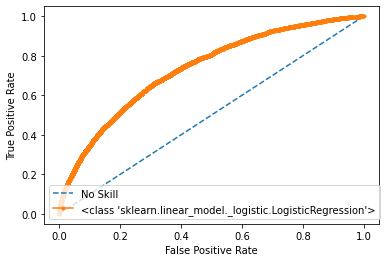

Roc_auc =  0.7348653925550878
Testing Accuracy  0.8475100035656273
F1 score  0.805247847647335
[[20878   411]
 [ 3438   514]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     21289
           1       0.56      0.13      0.21      3952

    accuracy                           0.85     25241
   macro avg       0.71      0.56      0.56     25241
weighted avg       0.81      0.85      0.81     25241



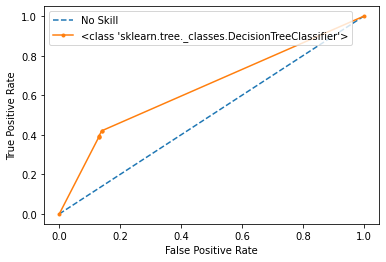

Roc_auc =  0.6403472025050286
Testing Accuracy  0.7953329899766254
F1 score  0.7990308457824541
[[18520  2769]
 [ 2397  1555]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     21289
           1       0.36      0.39      0.38      3952

    accuracy                           0.80     25241
   macro avg       0.62      0.63      0.63     25241
weighted avg       0.80      0.80      0.80     25241



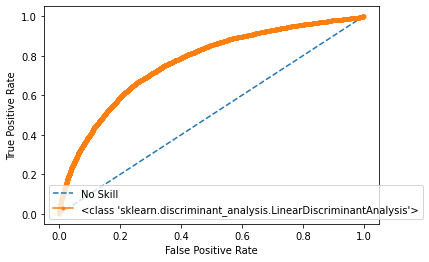

Roc_auc =  0.7662389630994928
Testing Accuracy  0.8477873301374748
F1 score  0.8161877229682937
[[20634   655]
 [ 3187   765]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.91     21289
           1       0.54      0.19      0.28      3952

    accuracy                           0.85     25241
   macro avg       0.70      0.58      0.60     25241
weighted avg       0.81      0.85      0.82     25241



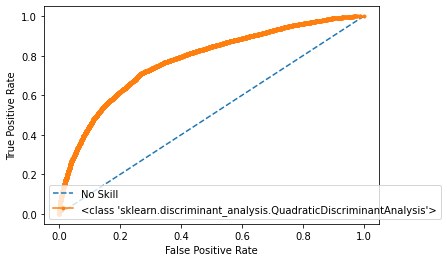

Roc_auc =  0.7782080536925515
Testing Accuracy  0.8436274315597638
F1 score  0.8308872148091565
[[19952  1337]
 [ 2610  1342]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     21289
           1       0.50      0.34      0.40      3952

    accuracy                           0.84     25241
   macro avg       0.69      0.64      0.66     25241
weighted avg       0.82      0.84      0.83     25241



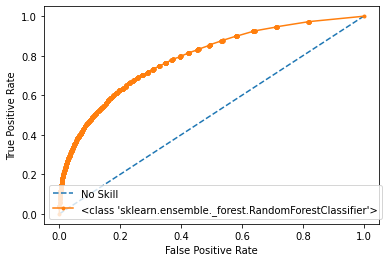

Roc_auc =  0.7891395510749217
Testing Accuracy  0.8565429261915138
F1 score  0.8423663044227832
[[20221  1068]
 [ 2553  1399]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     21289
           1       0.57      0.35      0.44      3952

    accuracy                           0.86     25241
   macro avg       0.73      0.65      0.68     25241
weighted avg       0.84      0.86      0.84     25241



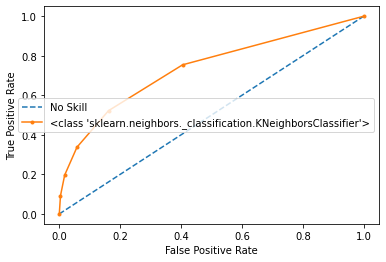

Roc_auc =  0.7346647783643755
Testing Accuracy  0.8473119131571649
F1 score  0.833534827372555
[[20053  1236]
 [ 2618  1334]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     21289
           1       0.52      0.34      0.41      3952

    accuracy                           0.85     25241
   macro avg       0.70      0.64      0.66     25241
weighted avg       0.83      0.85      0.83     25241



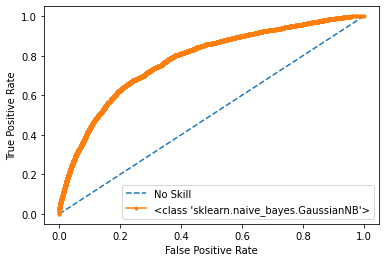

Roc_auc =  0.7797978366163134
Testing Accuracy  0.8375658650608138
F1 score  0.8261417846111422
[[19803  1486]
 [ 2614  1338]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     21289
           1       0.47      0.34      0.39      3952

    accuracy                           0.84     25241
   macro avg       0.68      0.63      0.65     25241
weighted avg       0.82      0.84      0.83     25241



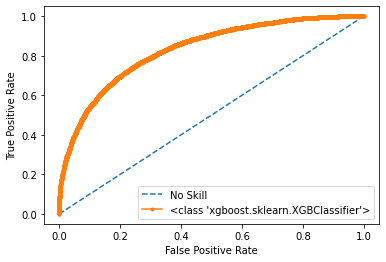

Roc_auc =  0.832172540018481
Testing Accuracy  0.8687056772711065
F1 score  0.8441772088571606
[[20813   476]
 [ 2838  1114]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     21289
           1       0.70      0.28      0.40      3952

    accuracy                           0.87     25241
   macro avg       0.79      0.63      0.66     25241
weighted avg       0.85      0.87      0.84     25241



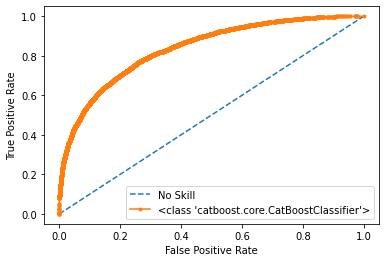

Roc_auc =  0.8372890190292339
Testing Accuracy  0.8740541182995919
F1 score  0.8556632862130691
[[20695   594]
 [ 2585  1367]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     21289
           1       0.70      0.35      0.46      3952

    accuracy                           0.87     25241
   macro avg       0.79      0.66      0.70     25241
weighted avg       0.86      0.87      0.86     25241



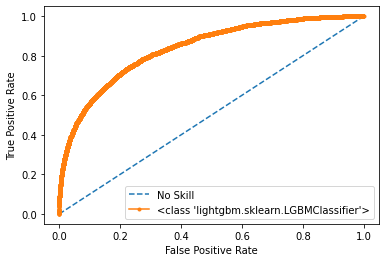

Roc_auc =  0.8379606192626137
Testing Accuracy  0.8735390832375897
F1 score  0.8531168182270873
[[20762   527]
 [ 2665  1287]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     21289
           1       0.71      0.33      0.45      3952

    accuracy                           0.87     25241
   macro avg       0.80      0.65      0.69     25241
weighted avg       0.86      0.87      0.85     25241



In [ ]:
training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

training_data = preprocessing_outlier_removal(training_data)

training_data['Crop_status'].replace([2], 1, inplace = True)

X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)


# #scaling
# scaled_col = ['Insects', 'Does_count', 'Number_of_Weeks_Used', 'Number_Weeks_does_not_used']
# features = X[scaled_col]
# scaler = StandardScaler().fit(features.values)
# features = scaler.transform(features.values)
# X[scaled_col] = features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

models = [
LogisticRegression(),
DecisionTreeClassifier(),
#SVC(probability = True),
LinearDiscriminantAnalysis(),
QuadraticDiscriminantAnalysis(),
RandomForestClassifier(random_state = 42),
KNeighborsClassifier(),
GaussianNB(),
XGBClassifier(random_state = 42),
CatBoostClassifier(random_state=42, verbose = False),
LGBMClassifier(random_state = 42)
]


for x in models:
  grs_rf = x
  grs_rf.fit(X_train, y_train)
  pred = grs_rf.predict(X_test)
  yhat = grs_rf.predict_proba(X_test)

  pos_probs = yhat[:, 1]

  pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

  fpr, tpr, _ = roc_curve(y_test, pos_probs)
  pyplot.plot(fpr, tpr, marker='.', label= str(grs_rf.__class__))
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.legend()
  # show the plot
  pyplot.show()
  roc_auc = roc_auc_score(y_test, pos_probs)
  print("Roc_auc = ", roc_auc)
  print_classfn_metrics(pred, y_test, y_proba = None, is_yproba = False)



#download_csv(prediction, 'catboost_smote_7500.csv')

# plot_roc(clf, x_test, y_test)


In [ ]:
training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

# training_data['categ_2_3'] = [1 if x == 2 or x == 3 else 0 for x in training_data['Category_of_Toxicant']]

# X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
# test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = False)

#doesnotusedclean up
training_data = training_data.loc[(training_data['Number_Weeks_does_not used'] < 43) and (training_data['Crop_status'] == 0)] 

# import seaborn as sns
# import matplotlib.pyplot as plt
feature_names = training_data.columns
for i in range(len(feature_names)-1):
    figure = plt.figure()
    ax = sns.boxplot(x='Crop_status', y=feature_names[i], data=training_data)



ValueError: ignored

In [ ]:
training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

# only classes 1 and 2

training_data_1_2 = training_data.loc[(training_data['Crop_status'] > 0)]
training_data_1_2['Crop_status'] = training_data_1_2['Crop_status'].map({2: 0, 1: 1})

X, y = set_input(training_data_1_2, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)


X, y = smote(X,y)

# #scaling
# scaled_col = ['Insects', 'Does_count', 'Number_of_Weeks_Used', 'Number_Weeks_does_not_used']
# features = X[scaled_col]
# scaler = StandardScaler().fit(features.values)
# features = scaler.transform(features.values)
# X[scaled_col] = features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)



mo = RandomForestClassifier(random_state = 42)

#mo = CalibratedClassifierCV(mo, cv = 3)
param_grid = {
              "max_depth"       : [2, 3, 4, 5, 6, 7, 8],
              "min_samples_split": [1, 2, 3,4, 5, 6, 7],
              'min_samples_leaf': [1,2,3,4,5,6,7],
              "n_estimators" : list(range(100,1500,50)),
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy']
              }


grs_rf = RandomizedSearchCV(mo, param_grid, scoring="f1", cv=5, verbose = 10, n_jobs = -1, n_iter = 5000)
grs_rf.fit(X_train, y_train)

#print(np.average(cross_val_score(model,training_data, y,cv=5)))

print(grs_rf.best_score_)
print(grs_rf.best_params_)

print(grs_rf.best_estimator_)



pred = grs_rf.predict(X_test)
yhat = grs_rf.predict_proba(X_test)

pos_probs = yhat[:, 1]

pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

fpr, tpr, _ = roc_curve(y_test, pos_probs)
pyplot.plot(fpr, tpr, marker='.', label= str(mo.__class__))
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
roc_auc = roc_auc_score(y_test, pos_probs)
print("Roc_auc = ", roc_auc)
print_classfn_metrics(pred, y_test, y_proba = None, is_yproba = False)



#download_csv(prediction, 'catboost_smote_7500.csv')

# plot_roc(clf, x_test, y_test)


Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  7

KeyboardInterrupt: ignored

In [ ]:
y_test.value_counts()

1    3691
2     693
Name: Crop_status, dtype: int64

In [ ]:
print(pd.DataFrame(prediction_1).value_counts())
print(pd.DataFrame(y_test['Crop_status_0']).value_counts())

1    25012
0     1388
dtype: int64
Crop_status_0
1                22016
0                 4384
dtype: int64


### **Methodical stacking with evaluation of the classifiers to pick for stacking**


In [ ]:
#Methodical stacking

NFOLDS = 5
SEED = 42
NROWS = None
n_classes=3


training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')


X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)

# X, y = smote(X,y)

#train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

#class_weights = compute_class_weight('balanced', np.sort(y.unique()), y.values)


# Scaling
# X_train = scale(X_train)
# X_val = scale(X_val)


# Initializing CatBoost classifier, fitting and then predicting
#cat_model = CatBoostClassifier(iterations=500, learning_rate=0.3, depth=5, loss_function='MultiClass', classes_count=3, logging_level='Silent', l2_leaf_reg=2, thread_count=4, class_weights=class_weights)
cat_model = CatBoostClassifier(
    max_depth = 5,
    iterations=888, 
    learning_rate=0.07, 
    loss_function='MultiClass',
    early_stopping_rounds = 200,
    random_seed = SEED,
    classes_count = 3,
    cat_features=[0,1,2,3,4,5,6,7, 8],
    leaf_estimation_method= 'Newton',
    random_strength = 0.9,
    boosting_type = 'Ordered',
    sampling_frequency= 'PerTreeLevel',
    l2_leaf_reg = 2
)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_val)
cat_preds = cat_preds.reshape((-1,)).astype(int)

clf_catb = CatBoostClassifier(
    max_depth = 5,
    iterations=888, 
    learning_rate=0.07, 
    loss_function='MultiClass',
    early_stopping_rounds = 200,
    random_seed = SEED,
    classes_count = 3,
    cat_features=[0,1,2,3,4,5,6,7, 8],
    leaf_estimation_method= 'Newton',
    random_strength = 0.9,
    boosting_type = 'Ordered',
    sampling_frequency= 'PerTreeLevel',
    l2_leaf_reg = 2
)
calibrated_clf_catboo = CalibratedClassifierCV(clf_catb, method='isotonic', cv=3)
calibrated_clf_catboo.fit(X_train, y_train)
calib_catb_preds = calibrated_clf_catboo.predict(X_val).astype(int)


# Initializing Random Forest classifier, fitting and then predicting
rfc_clf = RandomForestClassifier(n_estimators=70, max_depth=5, max_features=0.8, n_jobs=4, random_state=SEED)
rfc_clf.fit(X_train, y_train)
rfc_preds = rfc_clf.predict(X_val).astype(int)

rfc_clf_calib = RandomForestClassifier(max_depth=5, max_features=0.8, n_jobs=4, random_state=SEED)
calibrated_clf_rf = CalibratedClassifierCV(rfc_clf_calib, method='isotonic', cv=5)
calibrated_clf_rf.fit(X_train, y_train)
calib_rfc_preds = calibrated_clf_rf.predict(X_val).astype(int)


# Initializing Adam Boost classifier, fitting and then predicting
ada_clf = AdaBoostClassifier(n_estimators=70, learning_rate=0.3)
ada_clf.fit(X_train, y_train)
ada_preds = ada_clf.predict(X_val).astype(int)
#, sample_weight=[class_weights[int(y_train.iloc[i])] for i in range(y_train.shape[0])]

# Initializing Bernoulli naive-bayes classifier, fitting and then predicting
bernoulli_clf = BernoulliNB()
bernoulli_clf.fit(X_train, y_train)
bernoulli_preds = bernoulli_clf.predict(X_val).astype(int)

bernoulli_clf_1 = BernoulliNB()
calibrated_clf_bl = CalibratedClassifierCV(bernoulli_clf_1, method='isotonic', cv=5)
calibrated_clf_bl.fit(X_train, y_train)
calib_bl_preds = calibrated_clf_bl.predict(X_val).astype(int)


# # Initializing Gaussian naive-bayes classifier, fitting and then predicting
# gaussian_clf = GaussianNB()
# gaussian_clf.fit(X_train, y_train, sample_weight=[class_weights[int(y_train.iloc[i])] for i in range(y_train.shape[0])])
# gaussian_preds = gaussian_clf.predict(X_val).astype(int)


#lr
lr = LogisticRegression(random_state=0, multi_class = 'ovr').fit(X_train, y_train)
lr_preds = lr.predict(X_val).astype(int)

#ridge classifier
rc_clf = RidgeClassifier(normalize=True).fit(X_train, y_train)
rc_preds = rc_clf.predict(X_val).astype(int)



xgbovr = XGBClassifier(max_depth = 5, learning_rate=0.1, random_state=SEED)
clf = OneVsRestClassifier(xgbovr)
xgbovr_preds = clf.fit(X_train, y_train).predict(X_val).astype(int)





0:	learn: 1.0169404	total: 600ms	remaining: 8m 52s
1:	learn: 0.9500264	total: 1s	remaining: 7m 25s
2:	learn: 0.8939338	total: 1.43s	remaining: 7m 3s
3:	learn: 0.8462203	total: 1.78s	remaining: 6m 33s
4:	learn: 0.8052380	total: 2.05s	remaining: 6m 2s
5:	learn: 0.7693720	total: 2.64s	remaining: 6m 28s
6:	learn: 0.7383987	total: 2.92s	remaining: 6m 7s
7:	learn: 0.7109104	total: 3.4s	remaining: 6m 14s
8:	learn: 0.6866889	total: 3.82s	remaining: 6m 13s
9:	learn: 0.6652551	total: 4.24s	remaining: 6m 12s
10:	learn: 0.6464758	total: 4.58s	remaining: 6m 5s
11:	learn: 0.6297603	total: 4.91s	remaining: 5m 58s
12:	learn: 0.6146117	total: 5.32s	remaining: 5m 57s
13:	learn: 0.6012985	total: 5.71s	remaining: 5m 56s
14:	learn: 0.5871794	total: 6.29s	remaining: 6m 6s
15:	learn: 0.5740487	total: 6.77s	remaining: 6m 8s
16:	learn: 0.5612964	total: 7.21s	remaining: 6m 9s
17:	learn: 0.5498370	total: 7.66s	remaining: 6m 9s
18:	learn: 0.5394682	total: 8.14s	remaining: 6m 12s
19:	learn: 0.5302230	total: 8.68s	

In [ ]:
bc = BaggingClassifier(random_state=SEED)
bc.fit(X_train, y_train)
bc_preds = bc.predict(X_val).astype(int)

bc_1 = BaggingClassifier(random_state=SEED)
calibrated_clf_bc = CalibratedClassifierCV(bc_1, method='isotonic', cv=5)
calibrated_clf_bc.fit(X_train, y_train)
calib_bc_preds = calibrated_clf_bc.predict(X_val).astype(int)

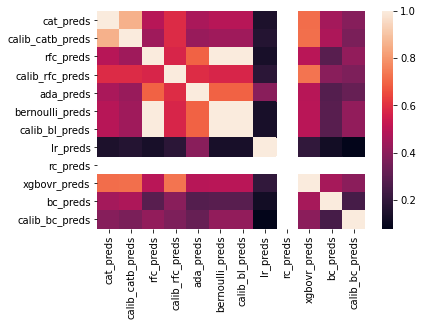

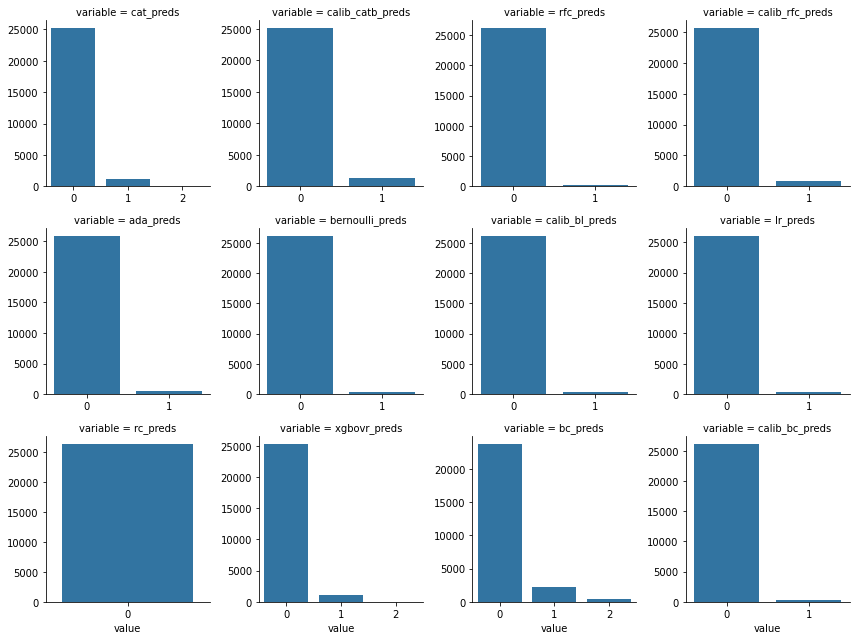

In [ ]:
# Combining all predictions and creating a heatplot of their correlations
all_preds = np.concatenate((cat_preds.reshape((-1, 1)), calib_catb_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, rfc_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, calib_rfc_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, ada_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, bernoulli_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, calib_bl_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, lr_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, rc_preds.reshape((-1, 1))), axis = 1)
all_preds = np.concatenate((all_preds, xgbovr_preds.reshape((-1, 1))), axis = 1)
all_preds = np.concatenate((all_preds, bc_preds.reshape((-1, 1))), axis = 1)
all_preds = np.concatenate((all_preds, calib_bc_preds.reshape((-1, 1))), axis = 1)
all_preds_df = pd.DataFrame(all_preds, columns=[ 'cat_preds', 'calib_catb_preds', 'rfc_preds', 'calib_rfc_preds', 'ada_preds', 'bernoulli_preds', 'calib_bl_preds', 'lr_preds', 'rc_preds', 'xgbovr_preds', 'bc_preds', 'calib_bc_preds'])
sns.heatmap(all_preds_df.corr())
plt.show()

#to try log loss calibration on bosted trees, rf and svm

# Visualizing and comparing the freqencies of predicted classes of all models
all_preds_flat = pd.melt(all_preds_df)
g = sns.FacetGrid(all_preds_flat, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')
plt.show()



In [ ]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2]), array([22016, 22016, 22017]))

In [ ]:


# Creating level1_train dataset
level1_train = np.zeros((X_train.shape[0], 18))
skf = StratifiedKFold(n_splits=5)

for tr_idx, te_idx in skf.split(X_train, y_train):
    
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    X_te, y_te = X_train.iloc[te_idx], y_train.iloc[te_idx]
    
    # cat_model.fit(X_tr, y_tr)
    # cat_preds = cat_model.predict_proba(X_te)
    # for i in range(3):
    #     level1_train[te_idx, i*7] = cat_preds[:, i]
    
    rfc_clf.fit(X_tr, y_tr)
    rfc_preds = rfc_clf.predict_proba(X_te)
    for i in range(3):
        level1_train[te_idx, i*7] = rfc_preds[:, i]
    
    
    bernoulli_clf.fit(X_tr, y_tr)
    bernoulli_preds = bernoulli_clf.predict_proba(X_te)
    for i in range(3):
        level1_train[te_idx, i*7+1] = bernoulli_preds[:, i]

    bernoulli_clf_1.fit(X_tr, y_tr)
    bernoulli_preds_1 = bernoulli_clf_1.predict_proba(X_te)
    for i in range(3):
        level1_train[te_idx, i*7+2] = bernoulli_preds_1[:, i]
    


# Creating level1_test dataset
level1_test = np.zeros((X_val.shape[0], 18))

# cat_model.fit(X_train, y_train)
# cat_preds = cat_model.predict_proba(X_val)
# for i in range(3):
#     level1_test[:, i*7] = cat_preds[:, i]

rfc_clf.fit(X_train, y_train)
rfc_preds = rfc_clf.predict_proba(X_val)
for i in range(3):
    level1_test[:, i*7] = rfc_preds[:, i]


bernoulli_clf.fit(X_train, y_train)
bernoulli_preds = bernoulli_clf.predict_proba(X_val)
for i in range(3):
    level1_test[:, i*7+1] = bernoulli_preds[:, i]
    

bernoulli_clf_1.fit(X_train, y_train)
bernoulli_preds_1 = bernoulli_clf_1.predict_proba(X_val)
for i in range(3):
    level1_test[:, i*7+2] = bernoulli_preds_1[:, i]




Learning rate set to 0.172769
0:	learn: 0.9041215	total: 177ms	remaining: 1m 28s
1:	learn: 0.7826800	total: 340ms	remaining: 1m 24s
2:	learn: 0.6983561	total: 501ms	remaining: 1m 23s
3:	learn: 0.6386466	total: 662ms	remaining: 1m 22s
4:	learn: 0.5941643	total: 830ms	remaining: 1m 22s
5:	learn: 0.5599162	total: 1s	remaining: 1m 22s
6:	learn: 0.5333390	total: 1.17s	remaining: 1m 22s
7:	learn: 0.5136648	total: 1.33s	remaining: 1m 22s
8:	learn: 0.4978004	total: 1.5s	remaining: 1m 21s
9:	learn: 0.4851689	total: 1.67s	remaining: 1m 21s
10:	learn: 0.4752233	total: 1.84s	remaining: 1m 21s
11:	learn: 0.4678031	total: 2s	remaining: 1m 21s
12:	learn: 0.4615693	total: 2.16s	remaining: 1m 20s
13:	learn: 0.4566686	total: 2.32s	remaining: 1m 20s
14:	learn: 0.4524385	total: 2.48s	remaining: 1m 20s
15:	learn: 0.4491080	total: 2.66s	remaining: 1m 20s
16:	learn: 0.4468437	total: 2.82s	remaining: 1m 20s
17:	learn: 0.4443289	total: 2.99s	remaining: 1m 20s
18:	learn: 0.4426555	total: 3.15s	remaining: 1m 19s

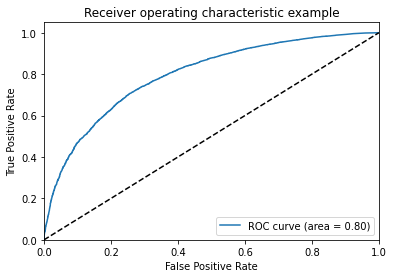

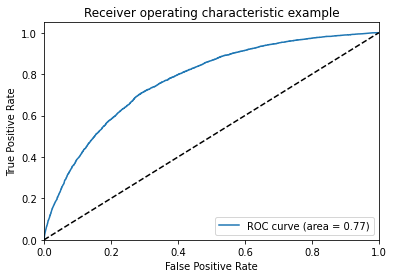

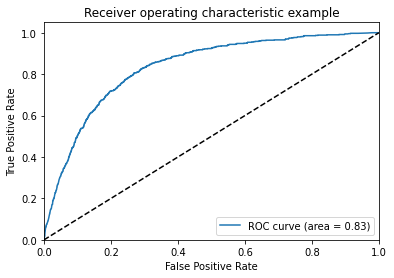

In [ ]:
#meta_clf = RidgeClassifier(normalize=True, class_weight='balanced')
meta_clf = CatBoostClassifier(loss_function='MultiClass', boosting_type='Ordered', iterations=500)
#meta_clf.fit(level1_train, y_train)
#meta_preds = meta_clf.predict(level1_test).astype(int)

calibrated_clf = CalibratedClassifierCV(meta_clf, method='isotonic', cv=7)
calibrated_clf.fit(level1_train, y_train)
ypreds = calibrated_clf.predict_proba(level1_test)


# sns.countplot(meta_subm['Target'])
# plt.show()
plot_roc(calibrated_clf, level1_test, y_val)
#print_classfn_metrics(meta_preds, level1_test, y_proba = None, is_yproba = False)

In [ ]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2]), array([22016,  3691,   693]))

In [ ]:
meta_preds
np.unique(meta_preds, return_counts=True)

(array([0, 1, 2]), array([17662,  6982,  1756]))

## **Calibrated CV**

In [ ]:
#calibration


training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')



X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)


# scaler = StandardScaler().fit(Xtrain)
# Xtrain = pd.DataFrame(scaler.transform(Xtrain), columns=list(Xtrain.columns))
# Xval = pd.DataFrame(scaler.transform(Xval), columns = list(Xval.columns))


clf = CatBoostClassifier(
    max_depth = 5,
    iterations=708, 
    learning_rate=0.1, 
    loss_function='MultiClass',
    early_stopping_rounds = 200,
    random_seed = 1,
    classes_count = 3,
    #cat_features=[0,1,2,3,4,5,6,7],
    leaf_estimation_method= 'Newton',
    random_strength = 0.9,
    boosting_type = 'Ordered',
    sampling_frequency= 'PerTreeLevel'
) 


calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=3)
calibrated_clf.fit(Xtrain, ytrain)
ypreds = calibrated_clf.predict_proba(Xval)
print("loss WITH calibration : ", log_loss(yval, ypreds, eps=1e-15, normalize=True))

#print_classfn_metrics(calibrated_clf.predict(Xval), y_test, y_proba = None, is_yproba = False)

## **ROC genesis with onevrest**

In [ ]:
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
n_classes = 3



training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

X, y = set_input(training_data, is_train_set = True, median_imputation = False, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = False, dummy = True)

y = label_binarize(y, classes=[0,1,2])


X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.33, random_state=0, stratify = y)

#x_train_smote, y_train_smote = smote(X_train, y_train)

# classifier

base = XGBClassifier(max_depth = 5, learning_rate=0.1)
# #base = CatBoostClassifier(
#     max_depth = 5,
#     # iterations=708, 
#     # learning_rate=0.1, 
#     # loss_function='MultiClass',
#     # early_stopping_rounds = 200,
#     # random_seed = 1,
#     # classes_count = 3,
#      cat_features=[1,2],
#     # leaf_estimation_method= 'Newton',
#     # random_strength = 0.9,
#     boosting_type = 'Ordered',
#     # sampling_frequency= 'PerTreeLevel'
# #) 
clf = OneVsRestClassifier(base)
y_score = clf.fit(X_train, y_train).predict_proba(X_test)


# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# print("ROC mean = ", np.mean(list(roc_auc.values())))
# # Plot of a ROC curve for a specific class
# for i in range(n_classes):
#     plt.figure()
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

# **Stacking cv classifier**


In [ ]:
# Stackingcvclassifier

NFOLDS = 5
SEED = 42
NROWS = None
n_classes=3




training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)


#train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

class_weights = compute_class_weight('balanced', np.sort(y.unique()), y.values)

#meta
#cat_model = CatBoostClassifier(iterations=500, learning_rate=0.3, depth=5, loss_function='MultiClass', classes_count=3, logging_level='Silent', l2_leaf_reg=2, thread_count=4, class_weights=class_weights)
rfc_clf = RandomForestClassifier(n_estimators=70, max_depth=5, max_features=0.8, n_jobs=4)
ada_clf = AdaBoostClassifier(n_estimators=70, learning_rate=0.3)
bernoulli_clf = BernoulliNB()
gaussian_clf = GaussianNB()
#svc_clf = SVC(class_weight = 'balanced', probability=True)
lr = LogisticRegression(random_state=0, class_weight = 'balanced', multi_class = 'ovr')

meta_clf = CatBoostClassifier(max_depth=5)

stack = StackingCVClassifier(classifiers=(rfc_clf, ada_clf, bernoulli_clf, gaussian_clf, lr),
                            meta_classifier=meta_clf, cv=7,
                            use_features_in_secondary=False,
                            store_train_meta_features=True,
                            shuffle=False, stratify = True, use_probas = True)

#stack.fit(X_train.values, y_train.values)
stack.fit(X_train.values, y_train.values)
X.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']
y_pred = stack.predict(X_val)
# print("Testing Accuracy ", accuracy_score(y_test, y_pred))
# print("F1 score ", f1_score(y_test, y_pred, average = 'weighted'))
# print(classification_report(y_test, y_pred))

### **Voting classifier**

0:	learn: 1.0656490	total: 273ms	remaining: 3m 13s
1:	learn: 1.0410564	total: 524ms	remaining: 3m 5s
2:	learn: 1.0177422	total: 799ms	remaining: 3m 7s
3:	learn: 1.0008410	total: 1.04s	remaining: 3m 2s
4:	learn: 0.9857090	total: 1.28s	remaining: 3m
5:	learn: 0.9703662	total: 1.52s	remaining: 2m 58s
6:	learn: 0.9592950	total: 1.77s	remaining: 2m 57s
7:	learn: 0.9488812	total: 2s	remaining: 2m 55s
8:	learn: 0.9381228	total: 2.28s	remaining: 2m 57s
9:	learn: 0.9283550	total: 2.52s	remaining: 2m 56s
10:	learn: 0.9212775	total: 2.8s	remaining: 2m 57s
11:	learn: 0.9133426	total: 3.09s	remaining: 2m 59s
12:	learn: 0.9068756	total: 3.34s	remaining: 2m 58s
13:	learn: 0.9017134	total: 3.61s	remaining: 2m 59s
14:	learn: 0.8974757	total: 3.86s	remaining: 2m 58s
15:	learn: 0.8917140	total: 4.15s	remaining: 2m 59s
16:	learn: 0.8875932	total: 4.43s	remaining: 3m
17:	learn: 0.8832599	total: 4.67s	remaining: 2m 59s
18:	learn: 0.8790151	total: 4.96s	remaining: 2m 59s
19:	learn: 0.8743387	total: 5.25s	rem

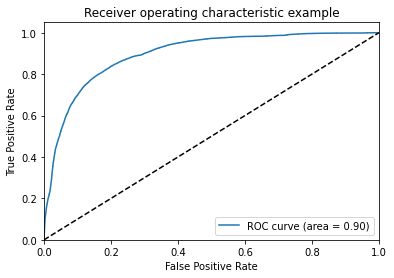

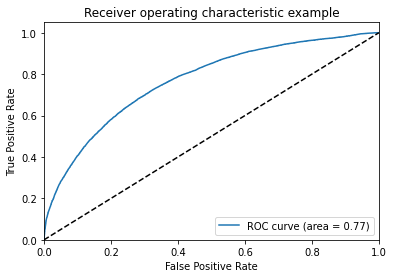

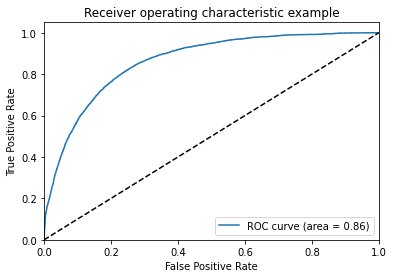

In [ ]:
# Voting Classifier - Multiple Model Ensemble 

training_data = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/train.xlsx')
test_df_off = pd.read_excel('/content/drive/My Drive/ML_Hackathon/ML_Hackathon/test.xlsx')

X, y = set_input(training_data, is_train_set = True, median_imputation = True, dummy = True)
test_df_off= set_input(test_df_off, is_train_set = False, median_imputation = True, dummy = True)

X, y = smote(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)


X_train = X_train.values 
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

cat_model = CatBoostClassifier(
    max_depth = 5,
    iterations=708, 
    learning_rate=0.1, 
    loss_function='MultiClass',
    early_stopping_rounds = 200,
    random_seed = SEED,
    classes_count = 3,
    #cat_features=[1, 5,6,7, 8],
    leaf_estimation_method= 'Newton',
    random_strength = 0.9,
    boosting_type = 'Ordered',
    sampling_frequency= 'PerTreeLevel'
)
cat_model = CalibratedClassifierCV(cat_model, method='isotonic', cv=3)

# rfc_clf = RandomForestClassifier(n_estimators=70, max_depth=5, max_features=0.8, n_jobs=4, class_weight='balanced', random_state=SEED)
# rfc_clf = CalibratedClassifierCV(rfc_clf, method='isotonic', cv=3)

bernoulli_clf = BernoulliNB()
bernoulli_clf = CalibratedClassifierCV(bernoulli_clf, method='isotonic', cv=3)

evc = VotingClassifier( estimators= [('cat_model', cat_model), ('bernoulli_clf', bernoulli_clf)], voting = 'soft')

evc.fit(X_train, y_train) #compute_sample_weight("balanced",y_train)

print("Score", evc.score(X_test, y_test))

pred = evc.predict(X_test)

plot_roc(evc, X_test, y_test)
#print_classfn_metrics(pred, X_test, y_proba = None, is_yproba = False)

